# Introduction to Gaussian Process Regression

A Gaussian process is a probability distribution over possible functions that fit a set of points.

In Gaussian process regression (GPR), the concept of a prior and posterior distribution is used to make predictions about the function that generated the data. The prior distribution is the initial belief about the function before any data is observed, and the posterior distribution is the updated belief about the function after the data is observed.

The prior distribution is defined by the mean function and covariance function (also known as the kernel) of the Gaussian process. These parameters can be specified by the user, or they can be estimated from the data. The posterior distribution is then computed using Bayesian inference, based on the observed data and the prior distribution.

The posterior distribution represents the updated belief about the function based on the observed data, and it can be used to make predictions about the function at new input points. The predictions are obtained by sampling from the posterior distribution, which gives a set of possible functions that could have generated the observed data. The mean of these functions can be used as the predicted output value, and the variance of the functions can be used to compute the uncertainty of the predictions.

The core definition of a Gaussian process states that for any finite set of input points $\boldsymbol{x} = \left\{ x_1, x_2, ..., x_n \right\}$, the corresponding function values $f(\boldsymbol{x}) = \left\{ f(x_1), f(x_2), ..., f(x_n) \right\}$ follow a multivariate Gaussian distribution. 

This distribution is characterized by a mean vector $\boldsymbol{\mu}$, where $\mu_i = m(x_i)$ with $m(\boldsymbol{x})$ being the mean function, 
and a covariance matrix $\boldsymbol{K}$, where $K_{ij} = k(x_i,x_j)$ with $k(\boldsymbol{x},\boldsymbol{x'})$ being the covariance or kernel function: 

$ f(x) \sim \mathcal{GP} \left( m(\boldsymbol{x}), k(\boldsymbol{x},\boldsymbol{x'}) \right) $,

we usually take the mean equal to zero, although it is not necessary.

In [2]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.95', 'grid.color': '.85'}
)
sns.set_palette(palette='deep')
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

## Target Function and Data Samples

We consider 

$ y = f(x)+ \epsilon $

being noisy observations of a target (true) function $f(x)$, where the residual errors $\epsilon$ are modeled as white noise meaning they are normally, independently and identically distributed with zero mean: 

$ \epsilon \sim \mathcal{N}(0, \sigma_n^2) $. 

As an example, let us consider function:

$ f(x) = \sin(2 \pi x) + \sin(4 \pi x) + \sin(7 \pi x) + x $.

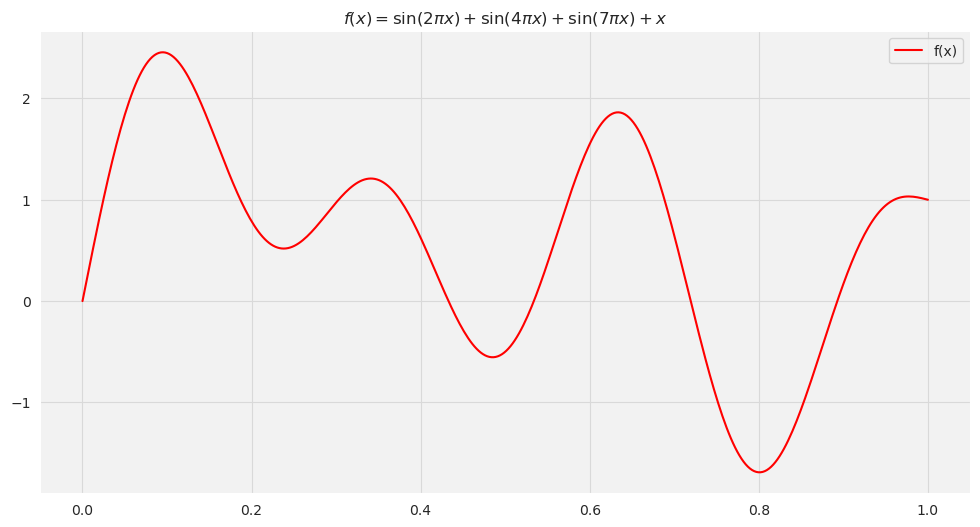

In [3]:
# Define the function
def f(x):
    f = np.sin(2 * np.pi * x) + np.sin(4 * np.pi * x) + np.sin(7 * np.pi * x) + x
    return f

# Number of training samples
n = 400

# Generate n evenly-spaced x values in [0,1]
x = np.linspace(start=0, stop=1, num=n)

# Evaluate the function at generated points
fx = f(x)

# Plot the function
fig, ax = plt.subplots()
sns.lineplot(x=x, y=fx, color='red', label='f(x)', ax=ax)
ax.legend(loc='upper right')
ax.set_title('$f(x) = \sin(2 \pi x) + \sin(4 \pi x) + \sin(7 \pi x) + x$');

Constructing a training set by adding noise to the training samples:

In [4]:
# Standard deviation of errors
sigma_n = 0.4
# Generate normally-distributed random observation errors
epsilon = np.random.normal(loc=0, scale=sigma_n, size=n)
# Add noise to observations
y = fx + epsilon

 Plotting the distribution of errors:

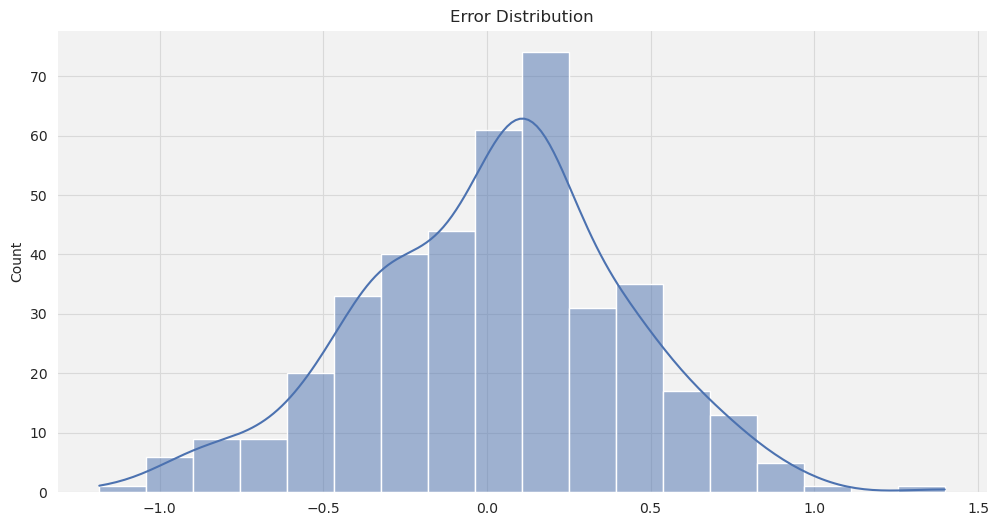

In [5]:
fig, ax = plt.subplots()
sns.histplot(epsilon, kde=True, ax=ax)
ax.set(title='Error Distribution');

Visualizing the noisy training data and the true function:

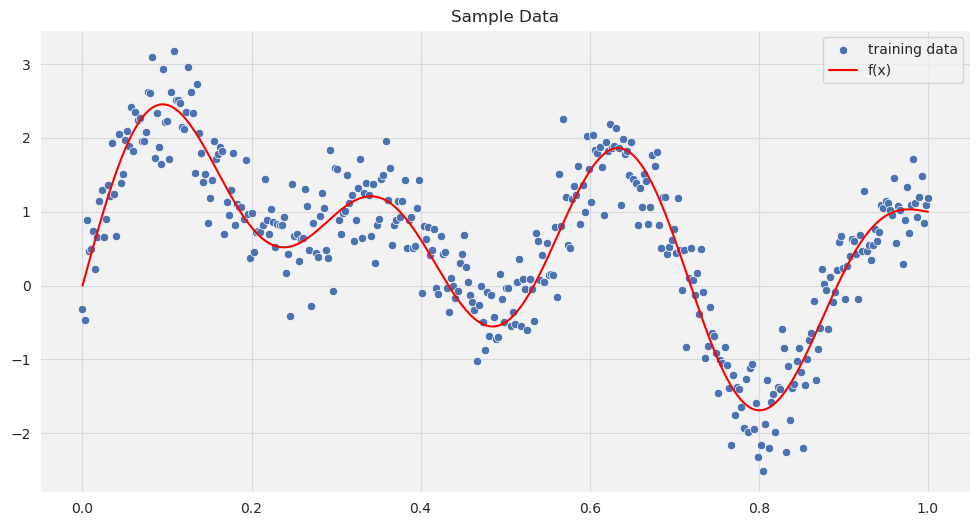

In [6]:
fig, ax = plt.subplots()

# Plot training data
sns.scatterplot(x=x, y=y, label='training data', ax=ax);
# Plot "true" function
sns.lineplot(x=x, y=fx, color='red', label='f(x)', ax=ax);

ax.set(title='Sample Data')
ax.legend(loc='upper right');

Generating a set of test data points, $x_*$, for which we want to make predictions:

In [7]:
n_star = 100
x_star = np.linspace(start=0, stop=1, num=n_star)

## Kernel Function

The covariance or kernel function $k(\boldsymbol{x},\boldsymbol{x'})$, which measures the degree of similarity between pairs of points, is often considered to be a function of the distance between $\boldsymbol{x}$ and $\boldsymbol{x'}$.

We are flexible in specifying the mathematical form of the covariance (kernel) function, as long as the covariance matrix is positive semidefinite. Selecting the form of the covariance function also permits us to encode assumptions about our data. 

A common choice of kernel function to compute covariances is the squared exponential: 

$ \text{Cov}\left( f(x),f(x') \right) = k(x,x') = \sigma_f^2 \exp \left(-\frac{1}{2\ell^2} \left( x - x' \right) ^2 \right) $, 

where $\ell$ (lenght scale) and $\sigma_f$ (signal variance) are hyperparameters.

In [8]:
# Define squared exponential kernel function
def kernel_function(x1, x2, length_scale=1.0, signal_variance=1.0):
    """
    Computes the squared exponential (RBF) kernel between two points.
    
    Parameters:
    -----------
    x1 : float
        First input point.
    x2 : float
        Second input point.
    length_scale : float, default=1.0
        Length scale of the kernel (controls smoothness).
    signal_variance : float, default=1.0
        Signal variance (controls amplitude).
        
    Returns:
    --------
    kernel : float
        Kernel value between x1 and x2.
    """    
    # The kernel formula
    kernel = signal_variance**2 * np.exp(-0.5 * (x1 - x2)**2 / length_scale**2)
    
    return kernel


Set hyperparameters of the kernel:

In [9]:
length_scale = 0.1
signal_variance = 2.0

## Covariance Matrices

A covariance matrix is constructed by evaluating the kernel function on all pairs of input data points. The kernel receives two points as an input and returns a similarity measure between those points in the form of a scalar.

Let us denote covariance matrices appllied to train, $x$, and test, $x_*$, points by 

$ K(X,X) \in M_{n \times n}(\mathbb{R}) $, 
$ K(X_*,X) \in M_{n_* \times n}(\mathbb{R}) $, 
$ K(X_*,X_*) \in M_{n_* \times n_*}(\mathbb{R}) $.

In [10]:
def compute_cov_matrix(a, b, length_scale=1.0, signal_variance=1.0):
    """
    Compute the covariance matrix between two sets of points using a kernel function.

    Parameters:
    -----------
    a : np.ndarray, shape (n_a,)
        First input array.
    b : np.ndarray, shape (n_b,)
        Second input array.
    length_scale : float, default=1.0
        Length scale for the kernel function.
    signal_variance : float, default=1.0
        Signal variance for the kernel function.

    Returns:
    --------
    K : np.ndarray, shape (n_a, n_b)
        Covariance matrix where each entry (i, j) is the result of 
        the kernel function applied to a[i] and b[j].
    """
    n_a = a.shape[0]
    n_b = b.shape[0]

    K = [kernel_function(i, j, length_scale, signal_variance) for (i, j) in itertools.product(a, b)]
    K = np.array(K).reshape(n_a, n_b)
    
    return K

Computing the covariance matrices:

In [11]:
# K(X,X)
K_xx = compute_cov_matrix(x, x, length_scale, signal_variance)
# K(X*,X)
K_star_x = compute_cov_matrix(x_star, x, length_scale, signal_variance)
# K(X*,X*)
K_star_star = compute_cov_matrix(x_star, x_star, length_scale, signal_variance)

## Joint Distribution

The joint distribution of training labels $y$ and $f_*$ (the predicted function values at test points $x_*$) is given by

$ \begin{pmatrix} y \\ f_* \end{pmatrix} \sim \mathcal{N}(0, \boldsymbol{K}) $,

where

$ \boldsymbol{K} = 
\begin{pmatrix} 
K(X, X) + \sigma_n^2 I & K(X, X_*) \\ 
K(X_*, X) & K(X_*, X_*)
\end{pmatrix} $,

the $\sigma_n^2 I$ term is added to the upper left component to account for noise in the observed points.

In [ ]:
# Adding the noise term to K(X,X)
K_xx += (sigma_n**2) * np.eye(n)

# Constructing the covariance matrix K from its components
K = np.block([
    [K_xx,     K_star_x.T ],
    [K_star_x, K_star_star]
    ])

K.shape

(500, 500)

In [13]:
# Check if the covariance matrix K is symmetric
np.all(K.T == K)

True

In [ ]:
# Check if the covariance matrix K is positive semi-definite
eigvals = np.linalg.eigvalsh(K)
np.all(eigvals >= -1e-8)

True

We can also visualize the covariance matrix:

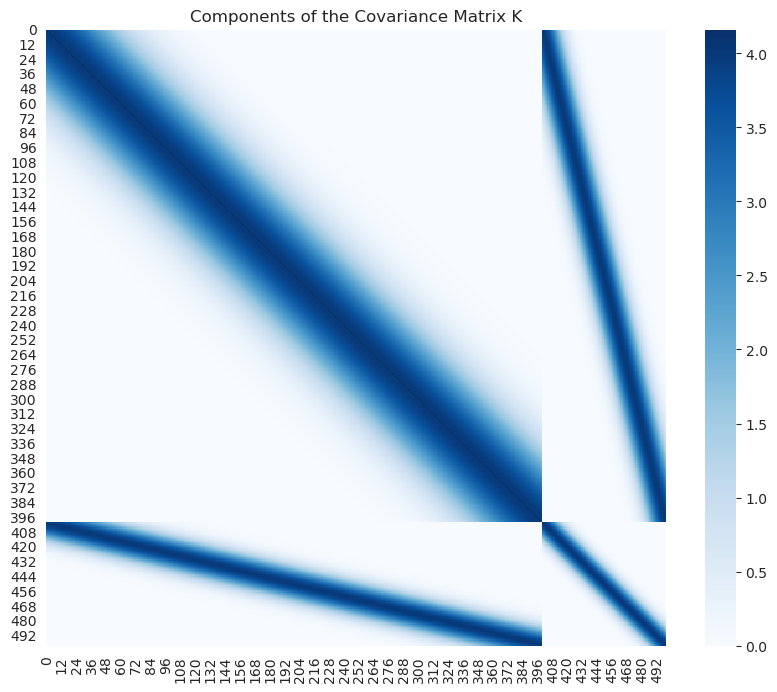

In [15]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data=K, cmap='Blues', ax=ax)
ax.set(title='Components of the Covariance Matrix K');

## Prior Distribution

From the *consistency requirement* of gaussian processes we know that the prior distribution for target functions
$f_*$ is 

$ \mathcal{N}(0, K(X_*, X_*)) $.

The *consistency requirement* (also known as the marginalization property) is ensuring that the marginal distributions derived from the joint distribution over any set of points match the distributions defined directly on subsets of those points. 

This property is automatically satisfied if the chosen kernel function $k(\boldsymbol{x},\boldsymbol{x'})$ is positive semidefinite. A positive semidefinite kernel guarantees that any covariance matrix $\boldsymbol{K}$ generated by evaluating the kernel on a finite set of points will be positive semidefinite, which, as we already mentioned, is a requirement for a valid covariance matrix of a multivariate Gaussian distribution.

Let us visualize some sample functions from this prior:

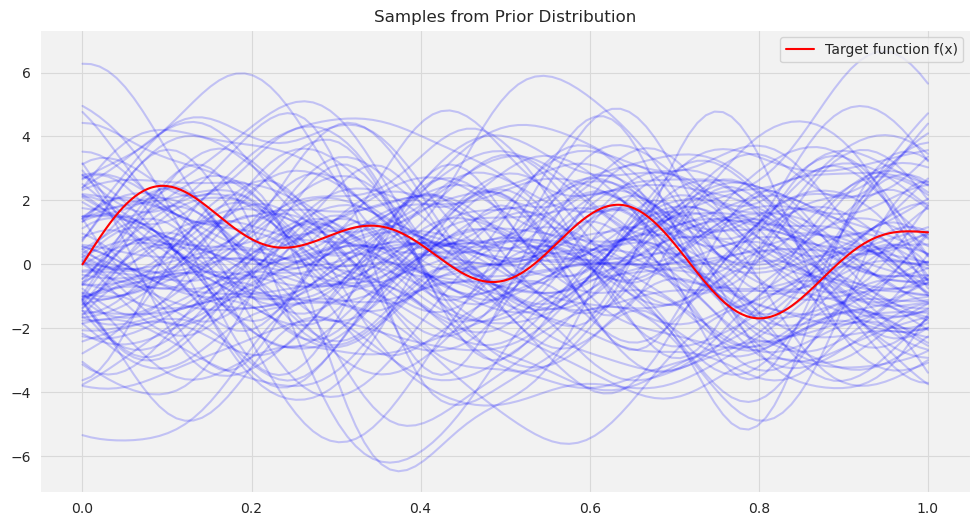

In [16]:
fig, ax = plt.subplots()

for i in range(0, 100):
    # Sample from prior distribution
    f_star = np.random.multivariate_normal(mean=np.zeros(n_star), cov=K_star_star)
    # Plot function
    sns.lineplot(x=x_star, y=f_star, color='blue', alpha=0.2, ax=ax)
    
# Plot "true" function
sns.lineplot(x=x, y=fx, color='red', label='Target function f(x)', ax=ax)

ax.set(title='Samples from Prior Distribution')
ax.legend(loc='upper right');

## Conditional Distribution

To get the posterior (conditional) distribution over functions, we need to restrict this prior distribution to contain only those functions which agree with the observed data points, that is, we are interested in computing $f_* \vert X,y,X_*$. 

$ f_* \vert X,y,X_* = \mathcal{N}(\bar{f}_*, \text{Cov}(f_*)) $.

The mean and covariance of this conditional distribution can be computed analyticaly, where the mean of the distribution i.e., our prediction is given by 

$ \bar{f}_* = K(X_*, X)\left( K(X, X) + \sigma_n^2I \right)^{-1} y $

and covariance i.e., prediction uncertainty is given by

$ \text{Cov}(f_*) = K(X_*, X_*) - K(X_*, X) \left( K(X, X) + \sigma_n^2I \right)^{-1} K(X, X_*) $.


**Note**: computing the inverse of $ \left( K(X, X) + \sigma_n^2I \right) $ is computationally expensive for larger data sets. A better approach is to use the Cholesky decomposition.


In [17]:
# Define a function to compute parameters of the posterior distribution
def compute_gpr_parameters(K_xx, K_star_x, K_star_star, y):
    """
    Compute the posterior mean and covariance of Gaussian Process.

    Parameters:
    -----------
    K_xx : np.ndarray, shape (n, n)
        Covariance matrix of training inputs.
    K_star_x : np.ndarray, shape (n_star, n)
        Covariance matrix between test and training inputs.
    K_star_star : np.ndarray, shape (n_star, n_star)
        Covariance matrix of test inputs.
    y : np.ndarray, shape (n,)
        Training target values.

    Returns:
    --------
    f_bar_star : np.ndarray, shape (n_star,)
        Posterior mean of the predictions at the test points x_star.
    cov_f_star : np.ndarray, shape (n_star, n_star)
        Posterior covariance of the predictions at the test points.
    """
    n = K_xx.shape[0]
    d = 1  # Output dimension (assumes scalar targets)

    # Compute inverse of K_xx
    K_inv = np.linalg.inv(K_xx)

    # Posterior mean
    f_bar_star = np.dot(K_star_x, np.dot(K_inv, y.reshape([n, d])))

    # Posterior covariance
    cov_f_star = K_star_star - np.dot(K_star_x, np.dot(K_inv, K_star_x.T))

    return f_bar_star, cov_f_star


In [18]:
# Compute posterior mean and covariance using the above function
f_bar_star, cov_f_star = compute_gpr_parameters(K_xx, K_star_x, K_star_star, y)

Let us visualize the covariance components.

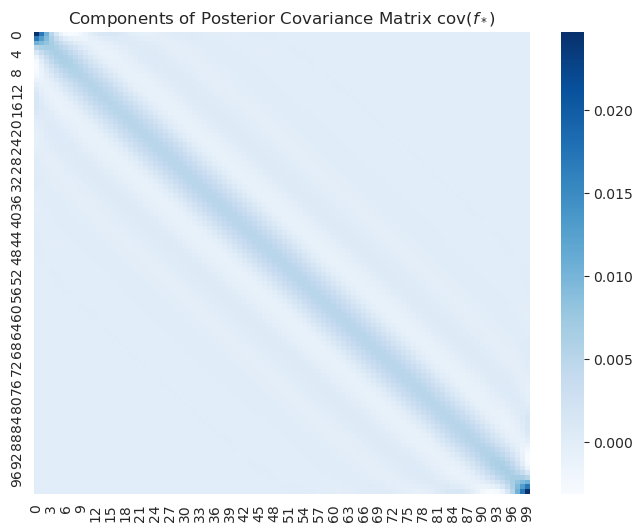

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(data=cov_f_star, cmap='Blues', ax=ax)
ax.set_title('Components of Posterior Covariance Matrix cov($f_*$)');

Sample functions from the posterior distribution:

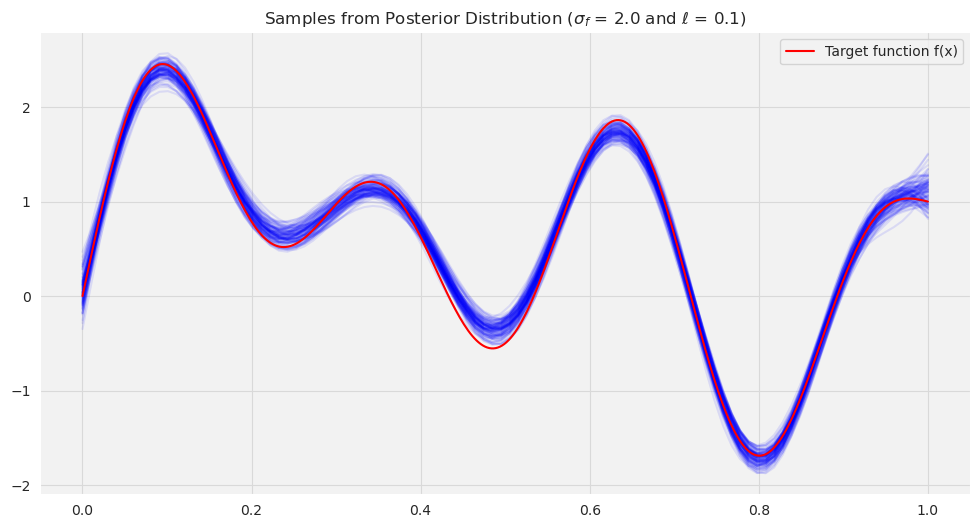

In [20]:
fig, ax = plt.subplots()

for i in range(0, 100):
    # Sample from posterior distribution
    f_star = np.random.multivariate_normal(mean=f_bar_star.squeeze(), cov=cov_f_star)
    # Plot function
    sns.lineplot(x=x_star, y=f_star, color="blue", alpha=0.1, ax=ax);

# Plot "true" function
sns.lineplot(x=x, y=fx, color='red', label = 'Target function f(x)', ax=ax)

ax.set(title=f'Samples from Posterior Distribution ($\sigma_f$ = {signal_variance} and $\ell$ = {length_scale})')
ax.legend(loc='upper right');

## Hyperparameters of the Kernel

We now explore effect of the hyperparameters $\left( \ell , \sigma_f \right)$ of the kernel function using two examples.
- $\ell$ (*length scale*): determines the degree of locality, i.e. how far the points correlate.
- $\sigma_f$ (*signal variance*): describes the amplitude of the function.

Example 1:

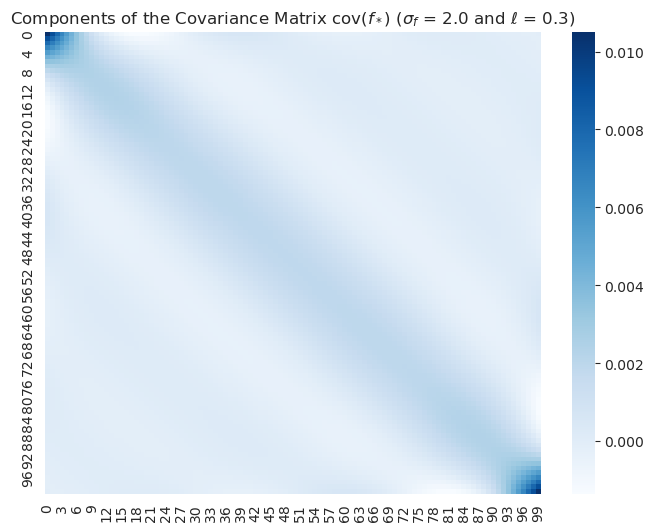

In [ ]:
length_scale = 0.3
signal_variance = 2.0

# Compute components of the covariance matrix
K_xx = compute_cov_matrix(x, x, length_scale, signal_variance) + (sigma_n**2) * np.eye(n)
K_star_x = compute_cov_matrix(x_star, x, length_scale, signal_variance)
K_star_star = compute_cov_matrix(x_star, x_star, length_scale, signal_variance)

# Compute posterior mean and covariance
f_bar_star, cov_f_star = compute_gpr_parameters(K_xx, K_star_x, K_star_star, y)

# Plot posterior covariance matrix components
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(data=cov_f_star, cmap='Blues', ax=ax)
ax.set(title=f'Components of the Covariance Matrix cov($f_*$) ($\sigma_f$ = {signal_variance} and $\ell$ = {length_scale})');

In this case the values of the posterior covariance matrix are less localized. This means that points far away from each other still have some correlation. 

Let us sample functions from this posterior distribution:

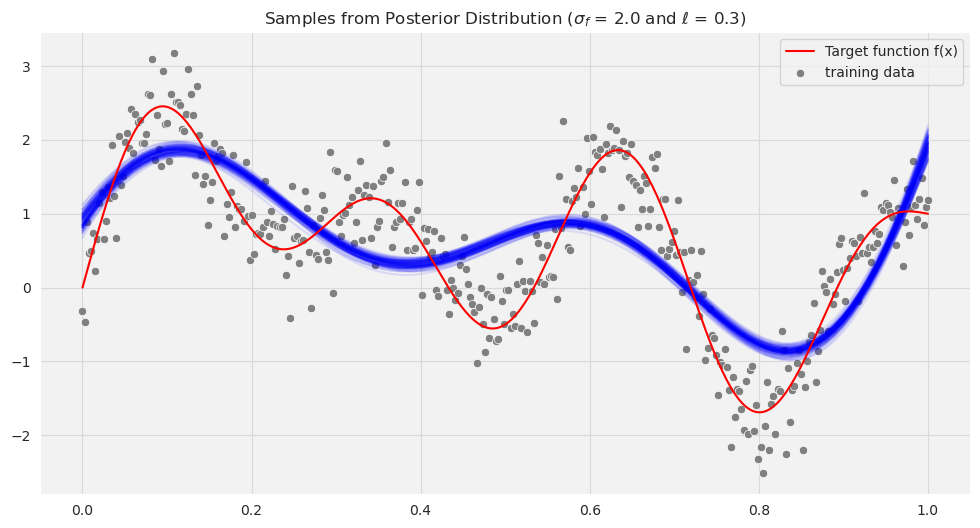

In [22]:
fig, ax = plt.subplots()

for i in range(0, 100):
    # Sample from posterior distribution
    f_star = np.random.multivariate_normal(mean=f_bar_star.squeeze(), cov=cov_f_star)
    # Plot function
    sns.lineplot(x=x_star, y=f_star, color="blue", alpha=0.1, ax=ax);
    
# Plot the "true" function
sns.lineplot(x=x, y=fx, color='red', label = 'Target function f(x)', ax=ax)
# Plot the training data
sns.scatterplot(x=x, y=y, color='gray', label='training data', ax=ax);

ax.set(title=f'Samples from Posterior Distribution ($\sigma_f$ = {signal_variance} and $\ell$ = {length_scale})')
ax.legend(loc='upper right');

A larger length scale results in a more global fit, thereby missing the more immediate changes in our target function.

Example 2:

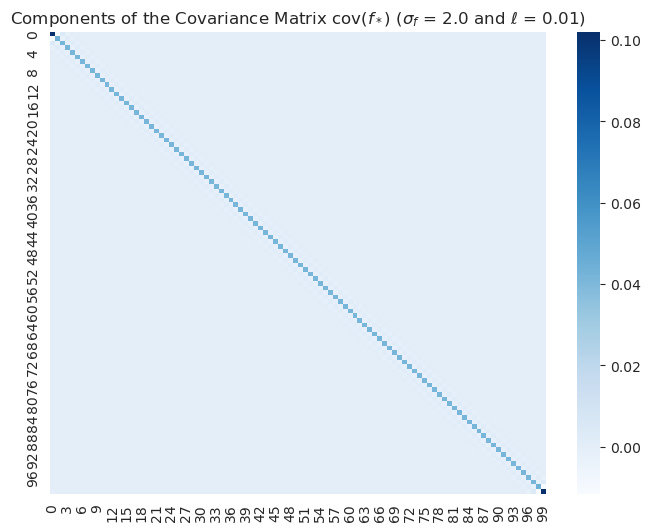

In [23]:
length_scale = 0.01
signal_variance = 2.0

# Compute components of the covariance matrix
K_xx = compute_cov_matrix(x, x, length_scale, signal_variance) + (sigma_n**2) * np.eye(n)
K_star_x = compute_cov_matrix(x_star, x, length_scale, signal_variance)
K_star_star = compute_cov_matrix(x_star, x_star, length_scale, signal_variance)

# Compute posterior mean and covariance
f_bar_star, cov_f_star = compute_gpr_parameters(K_xx, K_star_x, K_star_star, y)

# Plot posterior covariance matrix components
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(data=cov_f_star, cmap='Blues', ax=ax)
ax.set(title=f'Components of the Covariance Matrix cov($f_*$) ($\sigma_f$ = {signal_variance} \
and $\ell$ = {length_scale})');

In contrast, we see that for smaller values of $\ell$, the values of the posterior covariance matrix are localized along the diagonal. This means that points far away have no effect on each other, i.e. the fit becomes more local. 

Let us sample functions from this posterior distribution:

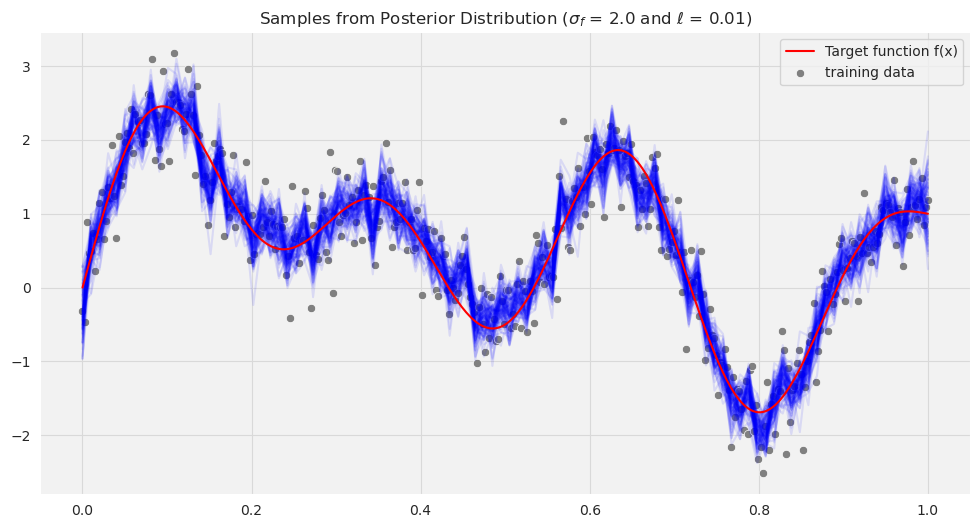

In [ ]:
fig, ax = plt.subplots()

for i in range(0, 100):
    # Sample from posterior distribution
    f_star = np.random.multivariate_normal(mean=f_bar_star.squeeze(), cov=cov_f_star)
    # Plot function
    sns.lineplot(x=x_star, y=f_star, color="blue", alpha=0.1, ax=ax);
    
# Plot the "true" function
sns.lineplot(x=x, y=fx, color='red', label = 'Target function f(x)', ax=ax)
# Plot the training data
sns.scatterplot(x=x, y=y, color='gray', label='training data', ax=ax);

ax.set(title=f'Samples from Posterior Distribution ($\sigma_f$ = {signal_variance} and $\ell$ = {length_scale})')
ax.legend(loc='upper right');

Therefore, the kernel hyperparameter $\ell$ encodes the “complexity” and “locality” of the model.

## Confidence Interval

We extend the range of $x$ values, in our target and predicted functions, to include a region not covered by the training set and will also compute the confidence intervals of the GP model.

In [25]:
# Generate evenly-spaced x values for prediction in an extended interval
X = np.linspace(start=0, stop=1.2, num=n)
X_star = np.linspace(start=0, stop=1.2, num=n_star)

# Reset kernel hyperparameters
length_scale = 0.1
signal_variance = 2.0

# Compute components of the covariance matrix
K_xx = compute_cov_matrix(x, x, length_scale, signal_variance) + (sigma_n**2) * np.eye(n)
K_star_x = compute_cov_matrix(X_star, x, length_scale, signal_variance)
K_star_star = compute_cov_matrix(X_star, X_star, length_scale, signal_variance)

# Compute posterior mean and covariance
f_bar_star, cov_f_star = compute_gpr_parameters(K_xx, K_star_x, K_star_star, y)

# Generate samples from posterior distribution
y_hat_samples = np.random.multivariate_normal(mean=f_bar_star.squeeze(), cov=cov_f_star, size=100)

# Compute mean of samples 
y_hat = np.apply_over_axes(func=np.mean, a=y_hat_samples, axes=0).squeeze()

# Compute standard deviation of samples
y_hat_sd = np.apply_over_axes(func=np.std, a=y_hat_samples, axes=0).squeeze()

Plotting the true function, training points, (mean) predicted function, and the confidence interval corresponding to two standard deviations.

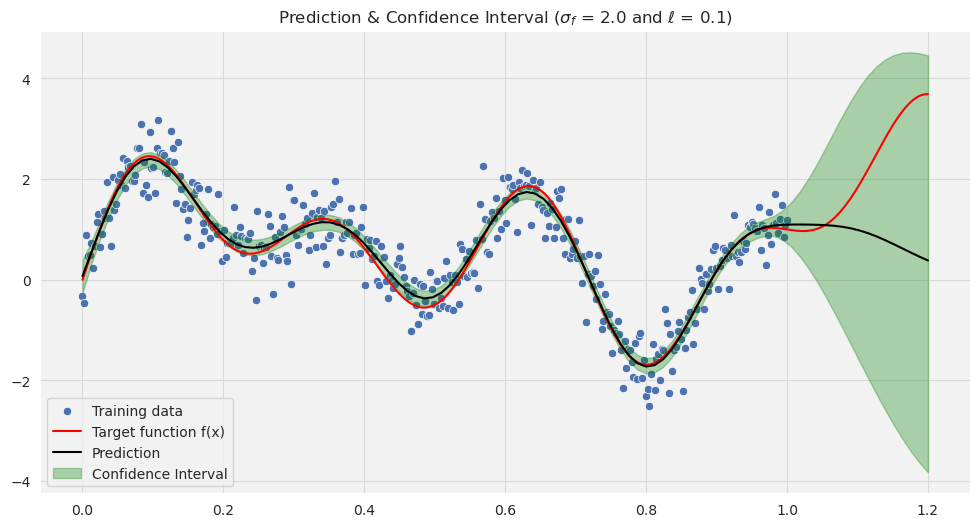

In [26]:
fig, ax = plt.subplots()

# Plot training data
sns.scatterplot(x=x, y=y, label='Training data', ax=ax)

# Plot "true" function
sns.lineplot(x=X, y=f(X), color='red', label='Target function f(x)', ax=ax);

# Plot prediction (i.e., posterior mean)
sns.lineplot(x=X_star, y=f_bar_star.squeeze(), color='black', label='Prediction', ax=ax)

# Plot confidence interval
ax.fill_between(
    x=X_star, 
    y1=(y_hat - 2*y_hat_sd), 
    y2=(y_hat + 2*y_hat_sd), 
    color='green', 
    alpha = 0.3, 
    label='Confidence Interval'
)

ax.set_title(f'Prediction & Confidence Interval ($\sigma_f$ = {signal_variance} and $\ell$ = {length_scale})')
ax.legend(loc='lower left');

GP predictions in regions not covered by the training set deviate from the true function and exhibit significantly higher variance, resulting in broader confidence interval.

## Hyperparameter Optimization

To optimize hyperparameters, $\ell$ and $\sigma_f$, of the kernel function, we perform a maximum likelihood estimation (MLE) by minimizing the negative logarithm of the marginal likelihood w.r.t. the kernel hyperparameters using a method such as BFGS.

### Marginal likelihood

The marginal likelihood represents the probability of the observed data $y$ given the inputs $X$ and hyperparameters $\theta$.

For a Gaussian Process with mean $0$ and covariance $K$, the marginal likelihood of the observed data $y$ at inputs $X$ and hyperparameters $\theta$ is 

$ \mathcal{p} ( y \vert X, \theta ) = \mathcal{N} \left( y \vert 0, K(X, X) + \sigma_n^2 I \right) $,

where $\theta = \left( \ell, \sigma_f^2 \right)$ are kernel hyperparameters (noise variance $\sigma_n$ is also typically included in $\theta$ and optimized along with kernel parameters).

From a computational point of view, it is more convenient to work with the logarithm of the marginal likelihood, which reads as

$ \log \mathcal{p}( y \vert X, \theta ) = 
-\frac{1}{2} \left( n \log 2 \pi + \log \vert K_n \vert + y^{\top} K_n^{-1} y \right) $,

where 
$ K_n = K(X, X) + \sigma_n^2 I $.

The first term, $n \log 2 \pi$, is a normalizing constant, the second term, $\log \lvert K_n \rvert$, is a complexity penalty that penalizes overly complex models (i.e., large determinant = more model flexibility), while the third term, $y^{\top} K_n^{-1} y$, which depends on the training outputs, measures how well the model fits the data. 

To optimize kernel hyperparameters $\theta$, we perform a maximum likelihood estimation, which means we maximize the log marginal likelihood as a function of $\theta$. Computationally, it is more convenient to reframe this estimation as a minimization of the negative logarithm of the marginal likelihood, 

$ \hat{\theta} = \arg_{\theta} \min \left( - \log \mathcal{p} \left( y \vert X, \theta \right) \right) $.

In [27]:
import scipy.optimize as opt

# Define the log marginal likelihood
def log_marginal_likelihood(params, x, y, sigma_n):
    """
    Compute the negative log marginal likelihood of a Gaussian Process.

    Parameters:
    -----------
    params : tuple of floats
        Hyperparameters of the kernel: (length_scale, signal_variance).
    x : np.ndarray, shape (n,)
        Training input points.
    y : np.ndarray, shape (n,)
        Training target values.
    sigma_n : float
        Standard deviation of observation noise.

    Returns:
    --------
    negative_log_likelihood : float
        The negative log marginal likelihood of the training data under the current hyperparameters.
    """
    length_scale, signal_variance = params

    # Compute covariance matrix with added noise variance
    K_n = compute_cov_matrix(x, x, length_scale, signal_variance) + sigma_n ** 2 * np.eye(n)

    # Compute inverse of the covariance matrix
    K_n_inv = np.linalg.inv(K_n)

    # Compute log determinant of K_n
    log_det_K_n = np.log(np.linalg.det(K_n))

    # Compute the negative log marginal likelihood
    negative_log_likelihood = 0.5 * (
        n * np.log(2 * np.pi) + log_det_K_n + np.dot(np.dot(y.T, K_n_inv), y)
    )

    return negative_log_likelihood

In [ ]:
# Initial guess for (length_scale, signal_variance)
initial_params = (1.0, 1.0)

# Optimize hyperparameters
result = opt.minimize(
    log_marginal_likelihood, 
    initial_params, 
    args=(x, y, sigma_n), 
    bounds=[(0.01, 10.0), (0.01, 10.0)], 
    method="L-BFGS-B", 
    options={'disp': True}
    )

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09714D+03    |proj g|=  9.00000D+00

At iterate    1    f=  2.40703D+02    |proj g|=  9.85441D+00

At iterate    2    f=  2.39959D+02    |proj g|=  7.55292D+00

At iterate    3    f=  2.39588D+02    |proj g|=  5.38330D-01

At iterate    4    f=  2.38690D+02    |proj g|=  2.86943D-01

At iterate    5    f=  2.37101D+02    |proj g|=  1.62103D-01

At iterate    6    f=  2.34855D+02    |proj g|=  9.46241D-01

At iterate    7    f=  2.34626D+02    |proj g|=  9.89230D+00
  Positive dir derivative in projection 
  Using the backtracking step 

At iterate    8    f=  2.33497D+02    |proj g|=  9.90268D+00
  Positive dir derivative in projection 
  Using the backtracking step 

At iterate    9    f=  2.33314D+02    |proj g|=  9.90555D+00

At iterate   10    f=  2.33260D+02    |proj g|=  1.48117D-01

At ite

In [29]:
# Get optimization results
print(f'Optimization {"Successful" if result.success else "Failed"}!')

optimal_length_scale, optimal_signal_variance = result.x
print("Optimal length_scale:", optimal_length_scale)
print("Optimal signal_variance:", optimal_signal_variance)

Optimization Successful!
Optimal length_scale: 0.09501153416324665
Optimal signal_variance: 1.4704572687972781


We now plot the predicted function and the confidence interval using the optimized hyperparameters.

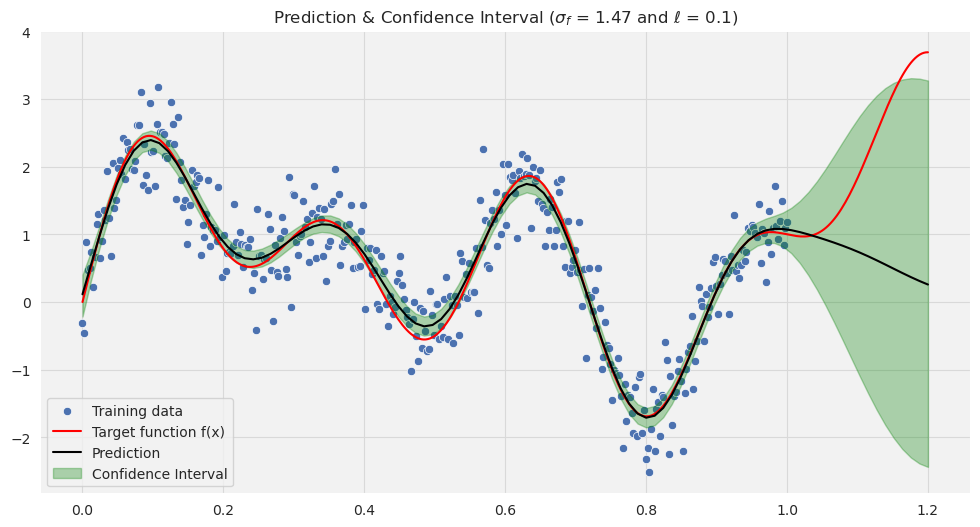

In [30]:
# Set kernel hyperparameters to optimized values
length_scale = np.round(optimal_length_scale, decimals=2)
signal_variance = np.round(optimal_signal_variance, decimals=2)

# Compute components of the covariance matrix
K_xx = compute_cov_matrix(x, x, length_scale, signal_variance) + (sigma_n**2) * np.eye(n)
K_star_x = compute_cov_matrix(X_star, x, length_scale, signal_variance)
K_star_star = compute_cov_matrix(X_star, X_star, length_scale, signal_variance)

# Compute posterior mean and covariance
f_bar_star, cov_f_star = compute_gpr_parameters(K_xx, K_star_x, K_star_star, y)

# Generate samples from posterior distribution
y_hat_samples = np.random.multivariate_normal(mean=f_bar_star.squeeze(), cov=cov_f_star, size=100)

# Compute mean of samples 
y_hat = np.apply_over_axes(func=np.mean, a=y_hat_samples, axes=0).squeeze()

# Compute standard deviation of samples
y_hat_sd = np.apply_over_axes(func=np.std, a=y_hat_samples, axes=0).squeeze()

# Plotting the results
fig, ax = plt.subplots()

# Plot training data
sns.scatterplot(x=x, y=y, label='Training data', ax=ax)

# Plot "true" function
sns.lineplot(x=X, y=f(X), color='red', label='Target function f(x)', ax=ax);

# Plot prediction (i.e., posterior mean)
sns.lineplot(x=X_star, y=f_bar_star.squeeze(), color='black', label='Prediction', ax=ax)

# Plot confidence interval
ax.fill_between(
    x=X_star, 
    y1=(y_hat - 2*y_hat_sd), 
    y2=(y_hat + 2*y_hat_sd), 
    color='green', 
    alpha = 0.3, 
    label='Confidence Interval'
)

ax.set_title(f'Prediction & Confidence Interval ($\sigma_f$ = {signal_variance} and $\ell$ = {length_scale})')
ax.legend(loc='lower left');

## Including Gradient of the Function

Since differentiation is a linear operator, the derivative of a Gaussian process (GP) is another GP. Thus we can use GPs to make predictions about derivatives, and also to make inference based on derivative information. 
In general, we can make inference based on the joint Gaussian distribution of function values and partial derivatives.

A fundamental property of GPs is that applying a linear operator to a GP results in another GP. 
Therefore, if $f(x)$ is a GP, its partial derivatives, $\partial f/\partial x_i$ (where $x_i$ is the $i$-th component of $x$), are also GPs.

When we want to learn both the function $f$ and its gradient $\nabla f$ (which consists of all partial derivatives $\partial f/\partial x_i$), we are essentially dealing with a vector-valued GP output at each point $x_i$: $\left[ f(x_i), \partial f(x_i)/\partial x_i \right]$.

Let $\mathrm{\textbf{y}_{ext}}$ be an extended observation set that also includes a set of derivative observations, 

$ \mathrm{\textbf{y}}_\mathrm{ext}=  \left[y_1,\cdots,y_n,\frac{\partial f(x_1)}{\partial x_1},\cdots,\frac{\partial f(x_n)}{\partial x_n}\right]^\top $.

We start by defining the derivative of our function:

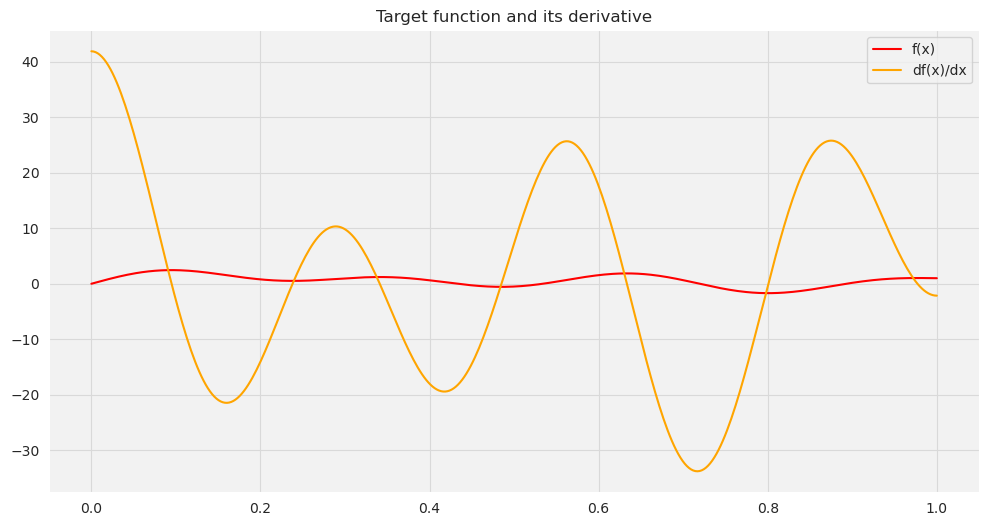

In [31]:
# Define derivative of the function
def df(x):
    df = np.cos(2 * np.pi * x) * 2 * np.pi \
       + np.cos(4 * np.pi * x) * 4 * np.pi \
       + np.cos(7 * np.pi * x) * 7 * np.pi \
       + 1
    return df

# Evaluate the function derivative at training points
dfx = df(x)

# Plot the function and its derivative
fig, ax = plt.subplots()
sns.lineplot(x=x, y=fx, color='red', label='f(x)', ax=ax)
sns.lineplot(x=x, y=dfx, color='orange', label='df(x)/dx', ax=ax)
ax.legend(loc='upper right')
ax.set_title('Target function and its derivative');

Next, we need to generate noisy data of function's derivative at points $x$. Observed function values and derivatives may often have different noise levels, which are incorporated by using differing $\sigma$ hyperparameters.

In [32]:
# Standard deviation of errors
sigma_d = 4.0
# Generate normally-distributed random observation errors
epsilon = np.random.normal(loc=0, scale=sigma_d, size=n)
# Compute noisy observations
dy = dfx + epsilon
# Extend the training labels to include derivativ values
y_ext = np.concatenate((y, dy))

To perform regression using the extended set of observations, we need to model the joint covariance between all components at different input points. 

We need to calculate not just $\text{Cov}\left( f(x), f(x') \right)$, but also: 

- $\text{Cov}\left( f(x), \partial f(x')/\partial x'_j \right)$: Covariance between the function value at $x$ and the $j$-th partial derivative at $x'$

- $\text{Cov}\left( \partial f(x)/\partial x_i, f(x') \right)$: Covariance between the $i$-th partial derivative at $x$ and the function value at $x'$

- $\text{Cov}\left( \partial f(x)/\partial x_i, \partial f(x')/\partial x'_j \right)$: Covariance between the $i$-th partial derivative at $x$ and the $j$-th partial derivative at $x'$

Under mild regularity conditions (which most standard kernel functions satisfy), we can interchange the order of differentiation and the covariance operation. 
Thus, using the definition $\text{Cov}\left( f(x), f(x') \right) = k(x, x')$, we get: 

- $\text{Cov}\left( f(x), \partial f(x')/\partial x'_j \right) = \partial k(x, x')/\partial x'_j$ 
(The partial derivative of the kernel with respect to the $j$-th component of its second argument)

- $\text{Cov}\left( \partial f(x)/\partial x_i, f(x') \right) = \partial k(x, x')/\partial x_i$ 
(The partial derivative of the kernel with respect to the i-th component of its first argument)

- $\text{Cov}\left( \partial f(x)/\partial x_i, \partial f(x')/\partial x'_j \right) = \partial^2 k(x, x')/\left(\partial x_i \partial x'_j\right)$ 
(The second-order mixed partial derivative of the kernel)

Accordingly, the extended kernel matrix is defined as

$ K_{ext}\left(X,X'\right) = 
\begin{pmatrix} 
k(x, x') & \frac{\partial}{\partial x'} k\left(x,x'\right) \\ 
\frac{\partial}{\partial x} k\left(x,x'\right) & \frac{\partial^2}{\partial x \partial x'} k\left(x,x'\right)
\end{pmatrix} $, 

with $n$ datapoints in $d$ dimensions, the complete joint distribution of $f$ and its $d$ partial derivatives involves $n(d+1)$ quantities.

### Derivatives of the squared exponential kernel

The first derivative of the squared exponential kernel with respect to $x$ (i.e., the covariance between a derivative value at $x$ and a function value at $x'$) is

$ \frac{\partial}{\partial x} k\left(x,x'\right) = -\ell^{-2} \left(x-x'\right) k\left(x,x'\right) $,

while the first derivative with respect to $x'$ (i.e., the covariance between a function value at $x$ and a derivative value at $x'$) is 

$ \frac{\partial}{\partial x'} k\left(x,x'\right) = -\frac{\partial}{\partial x} k\left(x,x'\right) $.

The second derivative of the squared exponential kernel with respect to both of its inputs (i.e., the covariance between a derivative value at $x$ and a derivative value at $x'$) is

$ \frac{\partial^2}{\partial x \partial x'} k\left(x,x'\right) = \left( \ell^{-2} - \ell^{-4} \left(x-x'\right)^2 \right) k\left(x,x'\right) $.

Let us define a function to compute the first and second derivative of the squared exponential kernel:

In [33]:
def kernel_derivative(x1, x2, length_scale, signal_variance):
    """
    Compute the first and second derivative of the squared exponential kernel with respect to x1.
    
    Parameters:
    -----------
    x1 : float
        First input point.
    x2 : float
        Second input point.
    
    Returns:
    --------
    dk : float
        First derivative of the kernel with respect to x1.
    d2k : float
        Second derivative of the kernel with respect to x1 and x2.
    """
    k = kernel_function(x1, x2, length_scale, signal_variance)
    diff = x1 - x2
    # First derivative
    dk = - (diff / length_scale**2) * k
    # Second derivative
    d2k = ( (1 / length_scale**2) - (diff**2 / length_scale**4) ) * k
    
    return dk, d2k

Next, we compute the components of extended kernel matrix $K_{ext}$:

In [ ]:
def compute_ext_cov_matrix(a, b, length_scale, signal_variance):
    """
    Compute the covariance matrix between two sets of points using a kernel function, and its derivatives.

    Parameters:
    -----------
    a : np.ndarray, shape (n_a,)
        First input array.
    b : np.ndarray, shape (n_b,)
        Second input array.
    length_scale : float, default=1.0
        Length scale for the kernel function.
    signal_variance : float, default=1.0
        Signal variance for the kernel function.

    Returns:
    --------
    K_ext : np.ndarray, shape (n_a*2, n_b*2)
        Covariance matrix where each entry (i, j) is the result of 
        the kernel function and its derivative functions applied to a[i] and b[j].
    """
    n_a = a.shape[0]
    n_b = b.shape[0]
    K, dK, d2K = [], [], []
    
    for (i, j) in itertools.product(a, b):
        
        kernel = kernel_function(i, j, length_scale, signal_variance)
        first_derivative, second_derivative = kernel_derivative(i, j, length_scale, signal_variance)
        
        K.append(kernel)
        dK.append(first_derivative)
        d2K.append(second_derivative)
    
    # Function-function
    K = np.array(K).reshape(n_a, n_b)
    # Derivative-function
    dK = np.array(dK).reshape(n_a, n_b)
    # Derivative-derivative
    d2K = np.array(d2K).reshape(n_a, n_b)
    
    # Assemble the extended K matrix
    K_ext = np.block([
        [K,  -dK],
        [dK, d2K]
        ])

    return K_ext

Constructing the full covariance matrix $\boldsymbol{K}$ from its components: 

$ \boldsymbol{K} = 
\begin{pmatrix} 
K_{ext}(X, X) + \sigma^2 I & K_{ext}(X, X_*) \\ 
K_{ext}(X_*, X) & K_{ext}(X_*, X_*)
\end{pmatrix} $.

**Note**: the signal noise for observed values ($\sigma_n$) and derivatives ($\sigma_d$) should be added to the diagonal components of the extended kernel matrix $K_{ext}(X,X)$.

In [ ]:
# K_ext(X,X)
K_xx_ext = compute_ext_cov_matrix(x, x, length_scale, signal_variance)
# K_ext(X*,X)
K_star_x_ext = compute_ext_cov_matrix(X_star, x, length_scale, signal_variance)
# K_ext(X*,X*)
K_star_star_ext = compute_ext_cov_matrix(X_star, X_star, length_scale, signal_variance)

# Add the noise value 𝜎_𝑛 to the upper left block (nxn) of K_xx_ext
K_xx_ext[:n, :n] += (sigma_n**2) * np.eye(n)
# Add the noise value 𝜎_d to the lower right block (nxn) of K_xx_ext
K_xx_ext[n:, n:] += (sigma_d**2) * np.eye(n)

K = np.block([
    [K_xx_ext,     K_star_x_ext.T ],
    [K_star_x_ext, K_star_star_ext]
    ])

print(K.shape)

# Check if the covariance matrix K is symmetric
print(np.all(K.T == K))

# Check if the covariance matrix K is positive semi-definite
eigvals = np.linalg.eigvalsh(K)
print(np.all(eigvals >= -1e-8))

(1000, 1000)
True
True


In [36]:
# Compute posterior mean and covariance
mean, cov = compute_gpr_parameters(K_xx_ext, K_star_x_ext, K_star_star_ext, y_ext)

Sample functions from the posterior distribution:

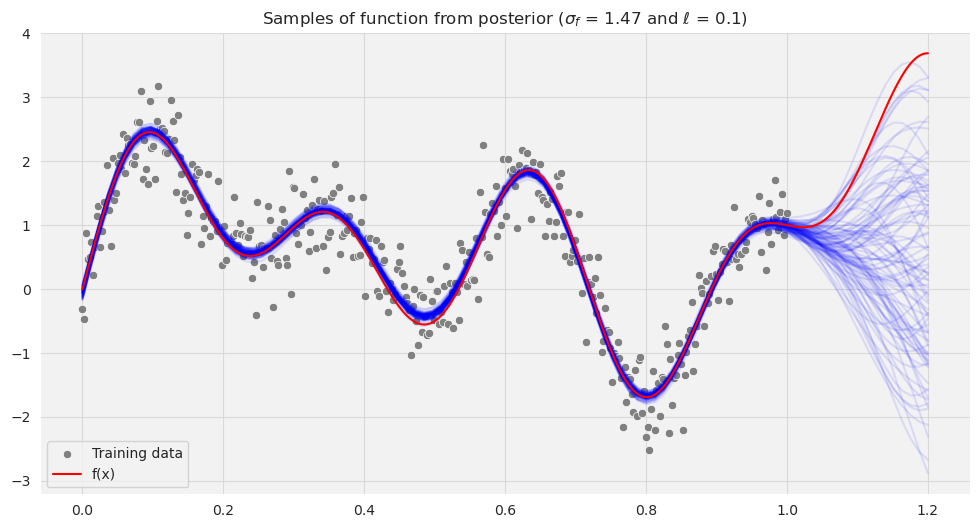

In [37]:
fig, ax = plt.subplots()

for i in range(0, 100):
    # Function samples from posterior distribution
    f_star = np.random.multivariate_normal(mean=mean[:n_star].squeeze(), cov=cov[:n_star, :n_star])
    # Plot function
    sns.lineplot(x=X_star, y=f_star, color="blue", alpha=0.1, ax=ax);

# Plot training data
sns.scatterplot(x=x, y=y, color='gray', label='Training data', ax=ax)

# Plot "true" function
sns.lineplot(x=X, y=f(X), color='red', label = 'f(x)', ax=ax)

ax.set(title=f'Samples of function from posterior ($\sigma_f$ = {signal_variance} and $\ell$ = {length_scale})')
ax.legend(loc='lower left');

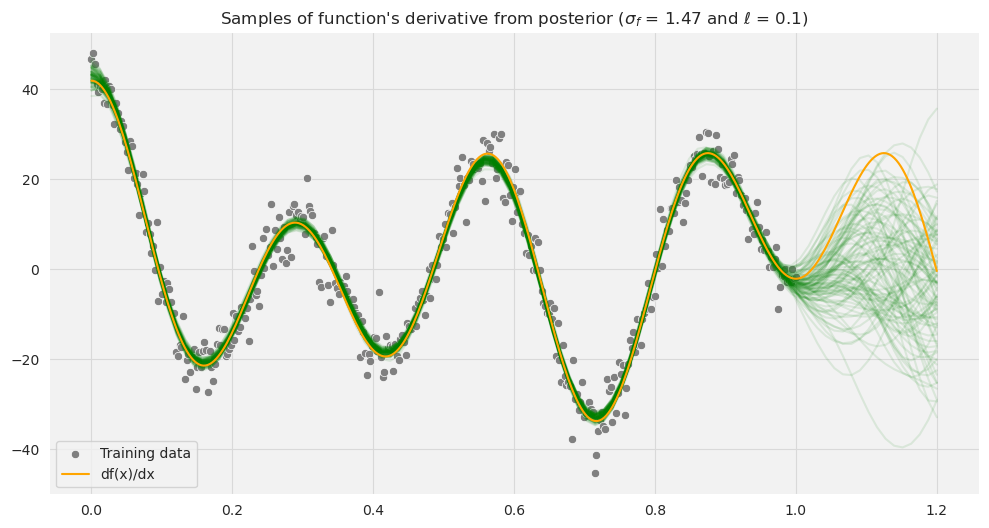

In [ ]:
fig, ax = plt.subplots()

for i in range(0, 100):
    # Derivative samples from posterior distribution
    df_star = np.random.multivariate_normal(mean=mean[n_star:].squeeze(), cov=cov[n_star:, n_star:])
    # Plot function
    sns.lineplot(x=X_star, y=df_star, color="green", alpha=0.1, ax=ax);

# Plot training data
sns.scatterplot(x=x, y=dy, color='gray', label='Training data', ax=ax)

# Plot "true" function
sns.lineplot(x=X, y=df(X), color='orange', label = 'df(x)/dx', ax=ax)

ax.set(title=f"Samples of function's derivative from posterior ($\sigma_f$ = {signal_variance} and $\ell$ = {length_scale})")
ax.legend(loc='lower left');

## Hyperparameter Optimization

Again, we perform hyperparameter optimization to find the best values for length scale ($\ell$), signal variance ($\sigma_f$), and also signal noise ($\sigma_n$ and $\sigma_d$) by maximizing the log marginal likelihood.

This time, we use the Cholesky decomposition to avoid directly computing $K_n^{-1} y$. 

$ K_n = LL^{\top} $ 

with $L$ being a lower-triangular matrix.

We first solve $Lz = y$ (forward substitution), then solve $L^{\top}\alpha = z$ (backward substitution), with 

$ \alpha = K_n^{-1} y $.

The log determinant of $K_n$ can also be computed using $L$ as 

$ \log \lvert K_n \rvert = 2 \sum \log L_{ii} $ 

with $L_{ii}$ being the diagonal elements of the Cholesky factor $L$.

In [39]:
# Define the log marginal likelihood
def log_marginal_likelihood_cholesky(params, x, y):
    """
    Compute the negative log marginal likelihood of Gaussian Process.

    Parameters:
    -----------
    params : tuple of floats
        Hyperparameters of the kernel: (length_scale, signal_variance, sigma_n, sigma_d).
    x : np.ndarray, shape (n,)
        Training input points.
    y : np.ndarray, shape (2*n,)
        Training target values.

    Returns:
    --------
    negative_log_likelihood : float
        The negative log marginal likelihood of the training data under the current hyperparameters.
    """
    length_scale, signal_variance, sigma_n, sigma_d = params

    # Compute covariance matrix
    K_n = compute_ext_cov_matrix(x, x, length_scale, signal_variance)
    # Add the noise value 𝜎_𝑛 to the upper left block
    K_n[:n, :n] += (sigma_n**2) * np.eye(n)
    # Add the noise value 𝜎_d to the lower right block
    K_n[n:, n:] += (sigma_d**2) * np.eye(n)
    
    try:
        L = np.linalg.cholesky(K_n)
    except np.linalg.LinAlgError:
        return np.inf

    # Solve Kn^−1.y using the Cholesky decomposition
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
    
    # Compute the log determinant of Kn using its Cholesky factor
    log_det_K_n = 2 * np.sum(np.log(np.diag(L)))

    negative_log_likelihood = 0.5 * ( np.dot(y.T, alpha) + log_det_K_n + len(y) * np.log(2 * np.pi) )

    return negative_log_likelihood

We optimize the kernel hyperparameters along with the signal noise $\sigma_n$ and $\sigma_d$:

In [ ]:
# Initial guess for (length_scale, signal_variance, sigma_n, sigma_d)
initial_params = (1.0, 1.0, 0.1, 0.1)

# Optimize hyperparameters
result = opt.minimize(
    log_marginal_likelihood_cholesky,
    initial_params,
    args=(x, y_ext),
    bounds=[(0.01, 10.0), (0.01, 10.0), (0.01, 5.0), (0.01, 10.0)], 
    method="L-BFGS-B",
    options={'disp': True}
    )

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.03569D+06    |proj g|=  9.90000D+00

At iterate    1    f=  3.02446D+03    |proj g|=  9.99000D+00

At iterate    2    f=  2.72628D+03    |proj g|=  9.98941D+00

At iterate    3    f=  2.65322D+03    |proj g|=  9.98910D+00

At iterate    4    f=  2.56146D+03    |proj g|=  9.98845D+00

At iterate    5    f=  2.50476D+03    |proj g|=  9.98771D+00

At iterate    6    f=  2.46198D+03    |proj g|=  9.98671D+00

At iterate    7    f=  2.43086D+03    |proj g|=  9.98545D+00

At iterate    8    f=  2.40390D+03    |proj g|=  9.98355D+00

At iterate    9    f=  2.38590D+03    |proj g|=  9.98127D+00

At iterate   10    f=  2.37158D+03    |proj g|=  9.97811D+00

At iterate   11    f=  2.36719D+03    |proj g|=  9.97642D+00

At iterate   12    f=  2.36632D+03    |proj g|=  9.97158D+00

At iterate   13    f=  2.3

In [41]:
# Get optimization results
print(f'Optimization {"Successful" if result.success else "Failed"}!')

opt_length_scale, opt_signal_variance, opt_sigma_n, opt_sigma_d = result.x
print("Optimal length_scale:", opt_length_scale)
print("Optimal signal_variance:", opt_signal_variance)
print("Optimal sigma_n:", opt_sigma_n)
print("Optimal sigma_d:", opt_sigma_d)

Optimization Successful!
Optimal length_scale: 0.12344801128574968
Optimal signal_variance: 2.4579024039808033
Optimal sigma_n: 0.3978102166483925
Optimal sigma_d: 3.8975183560596016


We now plot the predicted function, its derivative and the confidence intervals using the optimized hyperparameters.

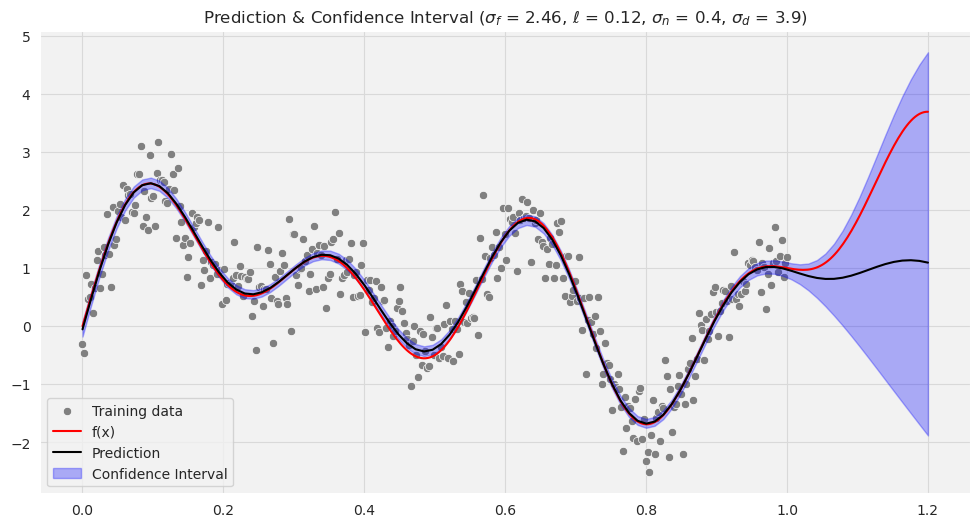

In [42]:
# Set kernel hyperparameters to optimized values
length_scale = np.round(opt_length_scale, decimals=2)
signal_variance = np.round(opt_signal_variance, decimals=2)
sigma_n = np.round(opt_sigma_n, decimals=2)
sigma_d = np.round(opt_sigma_d, decimals=2)

# Compute components of the covariance matrix
K_xx_ext = compute_ext_cov_matrix(x, x, length_scale, signal_variance)
K_star_x_ext = compute_ext_cov_matrix(X_star, x, length_scale, signal_variance)
K_star_star_ext = compute_ext_cov_matrix(X_star, X_star, length_scale, signal_variance)

# Add the noise value 𝜎_𝑛 to the upper left block (nxn) of K_xx_ext
K_xx_ext[:n, :n] += (sigma_n**2) * np.eye(n)
# Add the noise value 𝜎_d to the lower right block (nxn) of K_xx_ext
K_xx_ext[n:, n:] += (sigma_d**2) * np.eye(n)

# Compute posterior mean and covariance
mean, cov = compute_gpr_parameters(K_xx_ext, K_star_x_ext, K_star_star_ext, y_ext)

# Generate samples from posterior distribution
y_hat_samples = np.random.multivariate_normal(mean=mean[:n_star].squeeze(), cov=cov[:n_star, :n_star], size=100)

# Compute mean of samples 
y_hat = np.apply_over_axes(func=np.mean, a=y_hat_samples, axes=0).squeeze()

# Compute standard deviation of samples
y_hat_sd = np.apply_over_axes(func=np.std, a=y_hat_samples, axes=0).squeeze()

# Plotting the results
fig, ax = plt.subplots()

# Plot training data
sns.scatterplot(x=x, y=y, color='gray', label='Training data', ax=ax)

# Plot "true" function
sns.lineplot(x=X, y=f(X), color='red', label = 'f(x)', ax=ax)

# Plot prediction (i.e., posterior mean)
sns.lineplot(x=X_star, y=mean[:n_star].squeeze(), color='black', label='Prediction', ax=ax)

# Plot confidence interval
ax.fill_between(
    x=X_star, 
    y1=(y_hat - 2*y_hat_sd), 
    y2=(y_hat + 2*y_hat_sd), 
    color='blue', 
    alpha = 0.3, 
    label='Confidence Interval'
)

ax.set_title(f'Prediction & Confidence Interval ($\sigma_f$ = {signal_variance}, \
$\ell$ = {length_scale}, $\sigma_n$ = {sigma_n}, $\sigma_d$ = {sigma_d})')
ax.legend(loc='lower left');

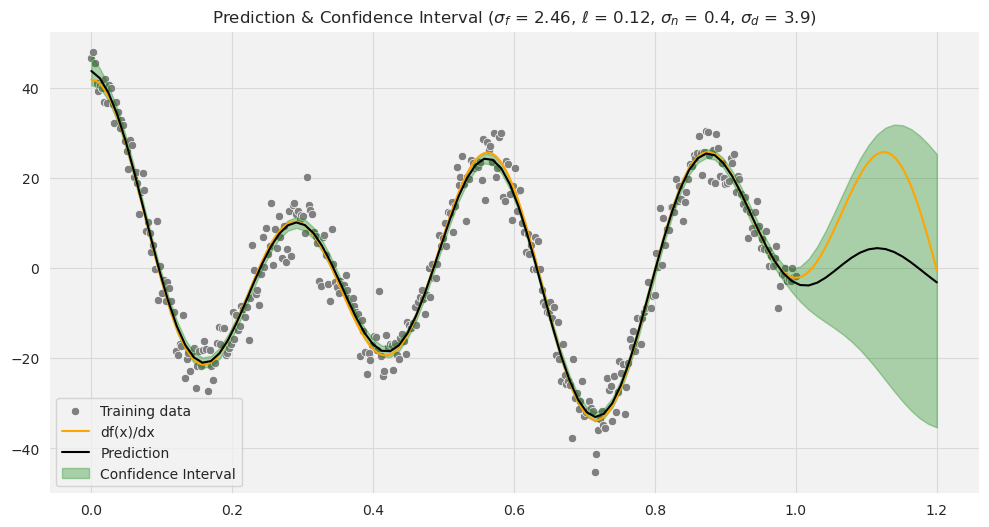

In [43]:
# Generate samples from posterior distribution
dy_hat_samples = np.random.multivariate_normal(mean=mean[n_star:].squeeze(), cov=cov[n_star:, n_star:], size=100)

# Compute mean of samples 
dy_hat = np.apply_over_axes(func=np.mean, a=dy_hat_samples, axes=0).squeeze()

# Compute standard deviation of samples
dy_hat_sd = np.apply_over_axes(func=np.std, a=dy_hat_samples, axes=0).squeeze()

# Plotting the results
fig, ax = plt.subplots()

# Plot training data
sns.scatterplot(x=x, y=dy, color='gray', label='Training data', ax=ax)

# Plot "true" function
sns.lineplot(x=X, y=df(X), color='orange', label = 'df(x)/dx', ax=ax)

# Plot prediction (i.e., posterior mean)
sns.lineplot(x=X_star, y=mean[n_star:].squeeze(), color='black', label='Prediction', ax=ax)

# Plot confidence interval
ax.fill_between(
    x=X_star, 
    y1=(dy_hat - 2*dy_hat_sd), 
    y2=(dy_hat + 2*dy_hat_sd), 
    color='green', 
    alpha = 0.3, 
    label='Confidence Interval'
)

ax.set_title(f'Prediction & Confidence Interval ($\sigma_f$ = {signal_variance}, \
$\ell$ = {length_scale}, $\sigma_n$ = {sigma_n}, $\sigma_d$ = {sigma_d})')
ax.legend(loc='lower left');